<a href="https://colab.research.google.com/github/olonok69/LLM_Notebooks/blob/main/quantization/Quantization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q transformers
!pip install accelerate
!pip install -i https://pypi.org/simple/ bitsandbytes


Looking in indexes: https://pypi.org/simple/


In [2]:
import torch

def absmax_quantize(X):
    # Calculate scale
    scale = 127 / torch.max(torch.abs(X))

    # Quantize
    X_quant = (scale * X).round()

    # Dequantize
    X_dequant = X_quant / scale

    return X_quant.to(torch.int8), X_dequant

In [3]:
def zeropoint_quantize(X):
    # Calculate value range (denominator)
    x_range = torch.max(X) - torch.min(X)
    x_range = 1 if x_range == 0 else x_range

    # Calculate scale
    scale = 255 / x_range

    # Shift by zero-point
    zeropoint = (-scale * torch.min(X) - 128).round()

    # Scale and round the inputs
    X_quant = torch.clip((X * scale + zeropoint).round(), -128, 127)

    # Dequantize
    X_dequant = (X_quant - zeropoint) / scale

    return X_quant.to(torch.int8), X_dequant

In [4]:
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch
torch.manual_seed(0)

# Set device to CPU for now
device = 'cpu'

# Load model and tokenizer
model_id = 'gpt2'
model = AutoModelForCausalLM.from_pretrained(model_id).to(device)
tokenizer = AutoTokenizer.from_pretrained(model_id)

# Print model size
print(f"Model size: {model.get_memory_footprint():,} bytes")

Model size: 510,342,192 bytes


In [5]:
# Extract weights of the first layer
weights = model.transformer.h[0].attn.c_attn.weight.data
print("Original weights:")
print(weights)

# Quantize layer using absmax quantization
weights_abs_quant, _ = absmax_quantize(weights)
print("\nAbsmax quantized weights:")
print(weights_abs_quant)

# Quantize layer using absmax quantization
weights_zp_quant, _ = zeropoint_quantize(weights)
print("\nZero-point quantized weights:")
print(weights_zp_quant)

Original weights:
tensor([[-0.4738, -0.2614, -0.0978,  ...,  0.0513, -0.0584,  0.0250],
        [ 0.0874,  0.1473,  0.2387,  ..., -0.0525, -0.0113, -0.0156],
        [ 0.0039,  0.0695,  0.3668,  ...,  0.1143,  0.0363, -0.0318],
        ...,
        [-0.2592, -0.0164,  0.1991,  ...,  0.0095, -0.0516,  0.0319],
        [ 0.1517,  0.2170,  0.1043,  ...,  0.0293, -0.0429, -0.0475],
        [-0.4100, -0.1924, -0.2400,  ..., -0.0046,  0.0070,  0.0198]])

Absmax quantized weights:
tensor([[-21, -12,  -4,  ...,   2,  -3,   1],
        [  4,   7,  11,  ...,  -2,  -1,  -1],
        [  0,   3,  16,  ...,   5,   2,  -1],
        ...,
        [-12,  -1,   9,  ...,   0,  -2,   1],
        [  7,  10,   5,  ...,   1,  -2,  -2],
        [-18,  -9, -11,  ...,   0,   0,   1]], dtype=torch.int8)

Zero-point quantized weights:
tensor([[-20, -11,  -3,  ...,   3,  -2,   2],
        [  5,   8,  12,  ...,  -1,   0,   0],
        [  1,   4,  18,  ...,   6,   3,   0],
        ...,
        [-11,   0,  10,  ...,  

In [6]:
import numpy as np
from copy import deepcopy

# Store original weights
weights = [param.data.clone() for param in model.parameters()]

# Create model to quantize
model_abs = deepcopy(model)

# Quantize all model weights
weights_abs = []
for param in model_abs.parameters():
    _, dequantized = absmax_quantize(param.data)
    param.data = dequantized
    weights_abs.append(dequantized)

# Create model to quantize
model_zp = deepcopy(model)

# Quantize all model weights
weights_zp = []
for param in model_zp.parameters():
    _, dequantized = zeropoint_quantize(param.data)
    param.data = dequantized
    weights_zp.append(dequantized)

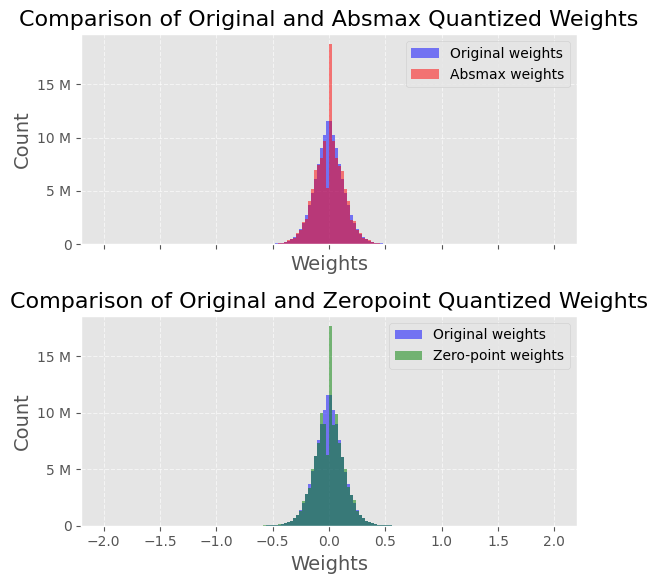

In [7]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# Flatten weight tensors
weights = np.concatenate([t.cpu().numpy().flatten() for t in weights])
weights_abs = np.concatenate([t.cpu().numpy().flatten() for t in weights_abs])
weights_zp = np.concatenate([t.cpu().numpy().flatten() for t in weights_zp])

# Set background style
plt.style.use('ggplot')

# Create figure and axes
fig, axs = plt.subplots(2, figsize=(6,6), dpi=100, sharex=True)

# Plot the histograms for original and zero-point weights
axs[0].hist(weights, bins=150, alpha=0.5, label='Original weights', color='blue', range=(-2, 2))
axs[0].hist(weights_abs, bins=150, alpha=0.5, label='Absmax weights', color='red', range=(-2, 2))

# Plot the histograms for original and absmax weights
axs[1].hist(weights, bins=150, alpha=0.5, label='Original weights', color='blue', range=(-2, 2))
axs[1].hist(weights_zp, bins=150, alpha=0.5, label='Zero-point weights', color='green', range=(-2, 2))

# Add grid
for ax in axs:
    ax.grid(True, linestyle='--', alpha=0.6)

# Add legend
axs[0].legend()
axs[1].legend()

# Add title and labels
axs[0].set_title('Comparison of Original and Absmax Quantized Weights', fontsize=16)
axs[1].set_title('Comparison of Original and Zeropoint Quantized Weights', fontsize=16)

for ax in axs:
    ax.set_xlabel('Weights', fontsize=14)
    ax.set_ylabel('Count', fontsize=14)
    ax.yaxis.set_major_formatter(ticker.EngFormatter()) # Make y-ticks more human readable

# Improve font
plt.rc('font', size=12)

plt.tight_layout()
plt.show()


In [8]:
def generate_text(model, input_text, max_length=50):
    input_ids = tokenizer.encode(input_text, return_tensors='pt').to(device)
    output = model.generate(inputs=input_ids,
                            max_length=max_length,
                            do_sample=True,
                            top_k=30,
                            pad_token_id=tokenizer.eos_token_id,
                            attention_mask=input_ids.new_ones(input_ids.shape))
    return tokenizer.decode(output[0], skip_special_tokens=True)

# Generate text with original and quantized models
original_text = generate_text(model, "I have nothing to offer but blood, toil, tears and sweat")
absmax_text   = generate_text(model_abs, "I have nothing to offer but blood, toil, tears and sweat")
zp_text       = generate_text(model_zp, "I have nothing to offer but blood, toil, tears and sweat")

print(f"Original model:\n{original_text}")
print("-" * 50)
print(f"Absmax model:\n{absmax_text}")
print("-" * 50)
print(f"Zeropoint model:\n{zp_text}")

Original model:
I have nothing to offer but blood, toil, tears and sweat, to the point where I cannot believe I would get rid from an old wound and then be able to look after myself and my family.

"I will tell you that
--------------------------------------------------
Absmax model:
I have nothing to offer but blood, toil, tears and sweat. I'll tell you what, if anything happens to me or the rest of America – I'm going to die. And all you crazy Jews and racists trying to make me the
--------------------------------------------------
Zeropoint model:
I have nothing to offer but blood, toil, tears and sweat to support my family through the hard work of our hard work.

My wife, my sons and I all will miss you and I'll miss you forever. - James H


## Perplexity

it can be used to evaluate how well the model has learned the distribution of the text it was trained on.

https://huggingface.co/spaces/evaluate-metric/perplexity#:~:text=Metric%3A%20perplexity&text=It%20is%20defined%20as%20the,co%2Fdocs%2Ftransformers%2Fperplexity

In [9]:
def calculate_perplexity(model, text):
    # Encode the text
    encodings = tokenizer(text, return_tensors='pt').to(device)

    # Define input_ids and target_ids
    input_ids = encodings.input_ids
    target_ids = input_ids.clone()

    with torch.no_grad():
        outputs = model(input_ids, labels=target_ids)

    # Loss calculation
    neg_log_likelihood = outputs.loss

    # Perplexity calculation
    ppl = torch.exp(neg_log_likelihood)

    return ppl

ppl     = calculate_perplexity(model, original_text)
ppl_abs = calculate_perplexity(model_abs, absmax_text)
ppl_zp  = calculate_perplexity(model_zp, absmax_text)

print(f"Original perplexity: {ppl.item():.2f}")
print(f"Absmax perplexity:   {ppl_abs.item():.2f}")
print(f"Zeropoint perplexity: {ppl_zp.item():.2f}")

Original perplexity: 17.58
Absmax perplexity:   22.87
Zeropoint perplexity: 23.30


In [10]:
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
import torch

nf4_config = BitsAndBytesConfig(
   load_in_4bit=True,
   bnb_4bit_quant_type="nf4",
   bnb_4bit_use_double_quant=True,
   bnb_4bit_compute_dtype=torch.bfloat16
)

In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model_int8 = AutoModelForCausalLM.from_pretrained(model_id,
                                             device_map='auto',
                                             quantization_config=nf4_config
                                             )
print(f"Model size: {model_int8.get_memory_footprint():,} bytes")

Model size: 134,060,568 bytes


In [12]:
# Generate text with quantized model
text_int8 = generate_text(model_int8, "I have nothing to offer but blood, toil, tears and sweat")

print(f"Original model:\n{original_text}")
print("-" * 50)
print(f"LLM.int8() model:\n{text_int8}")

Original model:
I have nothing to offer but blood, toil, tears and sweat, to the point where I cannot believe I would get rid from an old wound and then be able to look after myself and my family.

"I will tell you that
--------------------------------------------------
LLM.int8() model:
I have nothing to offer but blood, toil, tears and sweat. You don't know what your destiny is to become the king of Babylon. And you know it," said the god. "'I'm not going to make any mistake for you


In [13]:
print(f"Perplexity (original):   {ppl.item():.2f}")

ppl = calculate_perplexity(model_int8, text_int8)
print(f"Perplexity (LLM.int8()): {ppl.item():.2f}")

Perplexity (original):   17.58
Perplexity (LLM.int8()): 20.20
